In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import random

In [7]:
import keras
from keras import layers
from keras.models import Model
from sklearn.utils import shuffle

In [8]:
x_real = np.load('/content/drive/MyDrive/ml-data/SokotoCoventryFingerprintDataset(SOCOFing)/x_real.npz')['data'].transpose(0,3,1,2)
y_real = np.load('/content/drive/MyDrive/ml-data/SokotoCoventryFingerprintDataset(SOCOFing)/y_real.npy')
x_hard = np.load('/content/drive/MyDrive/ml-data/SokotoCoventryFingerprintDataset(SOCOFing)/x_hard.npz')['data'].transpose(0,3,1,2)
y_hard = np.load('/content/drive/MyDrive/ml-data/SokotoCoventryFingerprintDataset(SOCOFing)/y_hard.npy')
x_medium = np.load('/content/drive/MyDrive/ml-data/SokotoCoventryFingerprintDataset(SOCOFing)/x_medium.npz')['data'].transpose(0,3,1,2)
y_medium = np.load('/content/drive/MyDrive/ml-data/SokotoCoventryFingerprintDataset(SOCOFing)/y_medium.npy')
x_easy = np.load('/content/drive/MyDrive/ml-data/SokotoCoventryFingerprintDataset(SOCOFing)/x_easy.npz')['data'].transpose(0,3,1,2)
y_easy = np.load('/content/drive/MyDrive/ml-data/SokotoCoventryFingerprintDataset(SOCOFing)/y_easy.npy')

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


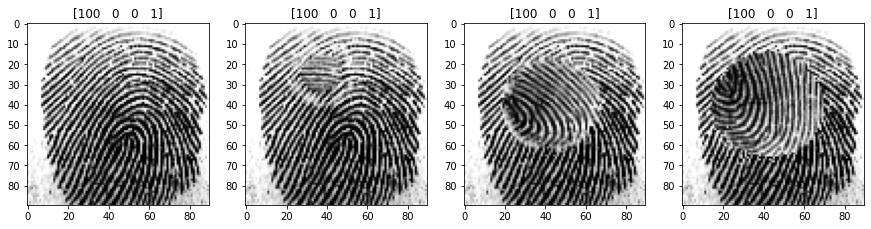

In [9]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)
plt.title(y_real[0])
plt.imshow(x_real[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 2)
plt.title(y_easy[0])
plt.imshow(x_easy[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 3)
plt.title(y_medium[0])
plt.imshow(x_medium[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 4)
plt.title(y_hard[0])
plt.imshow(x_hard[0].squeeze(), cmap='gray')

In [10]:
x_data = np.concatenate([x_easy, x_medium, x_hard], axis=0)
y_data = np.concatenate([y_easy, y_medium, y_hard], axis=0)
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1)
print(x_data.shape, y_data.shape)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(49270, 1, 90, 90) (49270, 4)
(44343, 1, 90, 90) (44343, 4)
(4927, 1, 90, 90) (4927, 4)


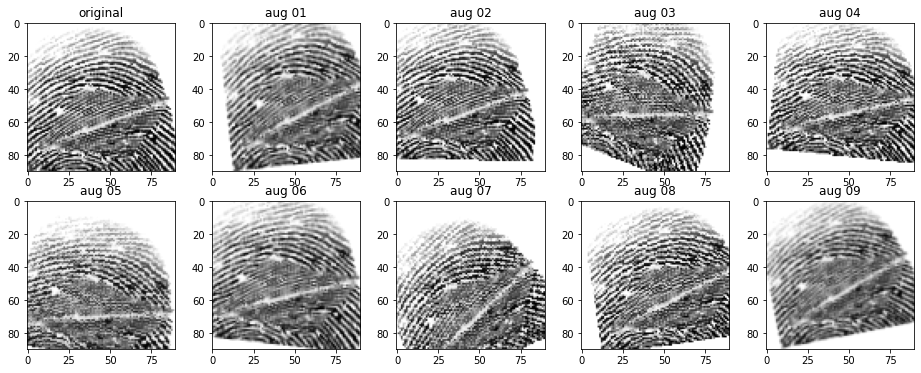

In [11]:
augs = [x_data[40000].squeeze()] * 9

seq = iaa.Sequential([
                      iaa.GaussianBlur(sigma=(0, 0.5)),
                      iaa.Affine(
                        scale={'x':(0.9, 1.1), 'y':(0.9, 1.1)},
                        translate_percent={'x':(-0.1, 0.1), 'y':(-0.1, 0.1)},
                        rotate=(-30, 30),
                        order=[0,1],
                        cval=255,
                      )
], random_order=True)

augs = seq.augment_images(augs)

plt.figure(figsize=(16,6))
plt.subplot(2,5,1)
plt.title("original")
plt.imshow(x_data[40000].squeeze(), cmap="gray")
for i, aug in enumerate(augs):
  plt.subplot(2,5,i+2)
  plt.title("aug %02d"%(int(i+1)))
  plt.imshow(aug.squeeze(), cmap="gray")

In [12]:
label_real_dict = {}
for i, y in enumerate(y_real):
  key = y.astype(str)
  key = ''.join(key).zfill(6)
  label_real_dict[key] = i

### START OF FUNCTIONS

In [13]:
from collections import OrderedDict

##### FUNCTIONS #########################

def im2col(input_data, FH, FW, stride=1, pad=0):
  """
  input_data : (N, C, H, W)
  fh, fw : int
  stride, pad : int
  """
  N, C, H, W = input_data.shape
  OH = (H + 2 * pad - FH) // stride + 1
  OW = (W + 2 * pad - FW) // stride + 1
  img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
  col = np.zeros((N, OH, OW, C, FH, FW))

  for h in range(OH):
    ii = h * stride
    for w in range(OW):
      jj = w * stride
      col[:, h, w, :, :, :] = img[:, :, ii:ii+FH, jj:jj+FW]
  col = col.reshape(N*OH*OW, -1)
  return col

def col2im(col, input_shape, FH, FW, stride=1, pad=0):
  N, C, H, W = input_shape
  OH = (H + 2 * pad - FH) // stride + 1
  OW = (W + 2 * pad - FW) // stride + 1
  col = col.reshape(N, OH, OW, C, FH, FW)
  img = np.zeros((N, C, H+2*pad, W+2*pad))
  for h in range(OH):
    ii = h * stride
    for w in range(OW):
      jj = w * stride
      img[:,:,ii:ii+FH, jj:jj+FW] = col[:, h, w, :, :, :]
  return img[:, :, pad:pad+H, pad:pad+W]

def gaussianInit(input_size, output_size, weight_init_std=0.01):
  return np.random.randn(input_size, output_size) * weight_init_std

def xavierInit(input_size, output_size, weight_init_std=0.01):
  return np.random.randn(input_size, output_size) / np.sqrt(input_size)

def heInit(input_size, output_size, weight_init_std=0.01):
  return np.random.randn(input_size, output_size) * np.sqrt( 2 / input_size)

##### SIDE LAYER #########################

class Sigmoid:
  def forward(self, x):
    self.y = 1. / (1 + np.exp(-x))
    return self.y
  
  def backward(self, dout):
    return dout * self.y * (1. - self.y)

class Relu:
  def __init__(self):
    self.mask = None

  def forward(self, X):
    self.mask = (X <= 0)
    self.out = X.copy()
    self.out[self.mask] = 0
    return self.out
  
  def backward(self, dout):
    dout[self.mask] = 0
    dx = dout
    return dx

def softmax(x):
  C = np.max(x)
  exps = np.exp(x - C)
  if x.ndim == 1:
    sum_exps = np.sum(exps)
    return exps / sum_exps
  sum_exps = np.sum(exps, axis=1)
  return (exps.T / sum_exps).T

def cross_entropy_error(y, t):
  if y.ndim == 1:
    y = y.reshape(1, y.size)
    t = t.reshape(1, t.size)
  batch_size = t.shape[0]
  return -np.sum( t * np.log(y + 1e-4) ) / batch_size

class BinaryCrossEntropy:
  def __init__(self):
    self.loss = None
    self.x = None
    self.t = None

  def forward(self, x, t):
    self.x = x
    self.t = t
    self.loss = -(t * np.log(x) + (1 - t) * np.log(1 - x))
    self.loss = np.sum(self.loss)
    return self.loss
  
  def backward(self, dout=1):
    return - (self.t/self.x - (1 - self.t)/(1- self.x)) * dout

class SoftmaxWithLoss:
  def __init__(self):
    self.loss = None
    self.y = None
    self.t = None
  
  def forward(self, x, t):
    self.t = t
    self.y = softmax(x)
    self.loss = cross_entropy_error(self.y, self.t)
    return self.loss
  
  def backward(self, dout=1):
    batch_size = self.t.shape[0]
    dx = (self.y - self.t) / batch_size
    return dx

##### CORE LAYER #########################

class Affine:
  def __init__(self, W, b):
    self.W = W
    self.b = b
    self.x = None
    self.original_x_shape = None
    self.dW = None
    self.db = None

  def forward(self, x):
    self.original_x_shape = x.shape
    self.x = x.reshape(x.shape[0], -1)
    return np.dot(self.x, self.W) + self.b
  
  def backward(self, dout):
    self.db = np.sum(dout, axis=0)
    self.dw = np.dot(self.x.T, dout)
    dx = np.dot(dout, self.W.T)
    return dx.reshape(self.original_x_shape)

class Convolution:
  def __init__(self, W, b, stride=1, pad=0):
    self.W = W
    self.b = b
    self.stride = stride
    self.pad = pad

  def forward(self, x):
    self.x = x
    N, C, H, W = self.x.shape
    FN, C, FH, FW = self.W.shape
    out_h = (H + 2*self.pad - FH) // self.stride + 1
    out_w = (W + 2*self.pad - FW) // self.stride + 1
    self.col = im2col(x, FH, FW, self.stride, self.pad)
    self.col_W = self.W.reshape(FN, -1).T
    out = np.dot(self.col, self.col_W) + self.b

    out = out.reshape(N, out_h, out_w, FN).transpose(0,3,1,2)
    return out
  
  def backward(self, dout):
    N, C, H, W = self.x.shape
    FN, C, FH, FW = self.W.shape
    out_h = (H + 2*self.pad - FH) // self.stride + 1
    out_w = (W + 2*self.pad - FW) // self.stride + 1
    # step1
    dout = dout.transpose(0,2,3,1).reshape(-1, FN)
    # step2 for db
    self.db = np.sum(dout, axis=0)
    # step3 for self.col * self.col_W
    dcol = np.dot(dout, self.col_W.T)
    dcol_W = np.dot(self.col.T, dout)
    # step4 for dx, dw
    dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)
    self.dw = dcol_W.T.reshape(FN, C, FH, FW)
    return dx

class Pooling:
  def __init__(self, pool_h, pool_w, stride=1, pad=0):
    self.pool_h = pool_h
    self.pool_w = pool_w
    self.stride = stride
    self.pad = pad
  
  def forward(self, x):
    N, C, H, W = x.shape
    out_h = (H - self.pool_h) // self.stride + 1
    out_w = (W - self.pool_w) // self.stride + 1
    col = im2col(x, self.pool_h, self.pool_w, stride=self.stride, pad=self.pad)
    col = col.reshape(-1, self.pool_h * self.pool_w)
    self.arg_max = np.argmax(col, axis=1)
    out = np.max(col, axis=1)
    out = out.reshape(N, out_h, out_w, C).transpose(0,3,1,2)
    self.x = x
    return out

  def backward(self, dout):
    N, C, H, W = self.x.shape
    out_h = (H - self.pool_h) // self.stride + 1
    out_w = (W - self.pool_w) // self.stride + 1
    dout = dout.transpose(0,2,3,1).reshape(N, out_h, out_w, C)

    dmax = np.zeros((dout.size, self.pool_h * self.pool_w))
    dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
    dmax = dmax.reshape(dout.shape + (self.pool_h * self.pool_w,))
    dcol = dmax.reshape(dmax.shape[0], dmax.shape[1], dmax.shape[2], -1)
    dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
    return dx

### END OF FUNCTIONS

In [14]:
class Substractor:
  def forward(self, x1, x2):
    return x1 - x2
  def backward(self, dout):
    return dout, -dout

In [15]:
class Flattener:
  def forward(self, x):
    self.batch_size = x.shape[0]
    self.origin_shape = x.shape
    self.out = x.reshape(self.batch_size, -1)
    return self.out
  
  def backward(self, dout):
    dout = dout.reshape(self.origin_shape)
    return dout

In [16]:
# DATA GEN
def dataGenerator(x, label, x_real, label_real_dict, batch_size=32):
  batch_indexes = np.random.choice(x.shape[0], batch_size)
  x1_batch = x[batch_indexes]
  label_batch = label[batch_indexes]

  x2_batch = np.empty((batch_size, 1, 90, 90), dtype=np.float32)
  y_batch = np.zeros((batch_size, 1), dtype=np.float32)

  seq = iaa.Sequential([
                        iaa.GaussianBlur(sigma=(0, 0.5)),
                        iaa.Affine(
                            scale={"x":(0.9, 1.1), "y":(0.9, 1.1)},
                            translate_percent={"x":(-0.1, 0.1), "y":(-0.1, 0.1)},
                            # rotate=(-30, 30),
                            order=[0,1],
                            cval=255
                        )
  ], random_order=True)
  x1_batch = seq.augment_images(x1_batch)
  for i, l in enumerate(label_batch):
    match_key = l.astype(str)
    match_key = ''.join(match_key).zfill(6)

    if random.random() > .5: # Put matched image
      x2_batch[i] = x_real[label_real_dict[match_key]]
      y_batch[i] = 1.
    else:
      while True:
        unmatch_key, unmatch_idex = random.choice(list(label_real_dict.items()))
        if unmatch_key != match_key:
          break
      x2_batch[i] = x_real[unmatch_idex]
      y_batch[i] = 0.
  return x1_batch.astype(np.float32) / 255, x2_batch.astype(np.float32) / 255, y_batch


In [17]:
x1_test, x2_test, t_test = dataGenerator(x_val, y_val, x_real, label_real_dict, batch_size=x_val.shape[0] //10)

In [20]:
class FingerprintRecognition:
  def __init__(self):
    # Params init
    self.params = {}
    ## 1 for Conv1
    self.params['W1'] = np.random.randn(32, 1, 3, 3) * 0.01
    self.params['b1'] = np.zeros(32)
    ## 2 for Conv2
    self.params['W2'] = np.random.randn(32, 32, 3, 3) * 0.01
    self.params['b2'] = np.zeros(32)
    ## 3 for Conv3
    self.params['W3'] = np.random.randn(32, 32, 3, 3) * 0.01
    self.params['b3'] = np.zeros(32)
    ## 4 for Affine1
    self.params['W4'] = heInit(2592, 64)
    self.params['b4'] = np.zeros(64)
    ## 5 for Affine2
    self.params['W5'] = xavierInit(64, 1)
    self.params['b5'] = np.zeros(1)

    # Layers init
    self.fex_layers = OrderedDict()
    self.cal_layers = OrderedDict()
    ## FeatureExtractor
    self.fex_layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'])
    self.fex_layers['Relu1'] = Relu()
    self.fex_layers['Pool1'] = Pooling(2, 2, stride=2)
    self.fex_layers['Conv2'] = Convolution(self.params['W2'], self.params['b2'])
    self.fex_layers['Relu2'] = Relu()
    self.fex_layers['Pool2'] = Pooling(2, 2, stride=2)
    ## cross layers
    self.substractor = Substractor()
    ## Cal layers
    self.cal_layers['Conv3'] = Convolution(self.params['W3'], self.params['b3'])
    self.cal_layers['Relu3'] = Relu()
    self.cal_layers['Pool3'] = Pooling(2, 2, stride=2)
    self.cal_layers['Flattener'] = Flattener()
    self.cal_layers['Affine1'] = Affine(self.params['W4'], self.params['b4'])
    self.cal_layers['Relu'] = Relu()
    self.cal_layers['Affine2'] = Affine(self.params['W5'], self.params['b5'])
    self.last_layer = BinaryCrossEntropy()
  
  def predict(self, x1, x2):
    for layer in self.fex_layers.values():
      x1 = layer.forward(x1)
      x2 = layer.forward(x2)
    x = self.substractor.forward(x1, x2)
    for layer in self.cal_layers.values():
      x = layer.forward(x)
    return x
  
  def loss(self, x1, x2, t):
    y = self.predict(x1, x2)
    return self.last_layer.forward(y, t)

  def accuracy(self, x1, x2, t):
    y = self.predict(x1, x2)
    ret = np.zeros(y.shape)
    ret[0.5 <= y] = 1
    accuracy = np.sum(ret == t) / y.size
    return accuracy

  def gradient(self, x1, x2, t):
    self.loss(x1, x2, t)
    dout = 1
    dout = self.last_layer.backward(dout)
    layers = list(self.cal_layers.values())
    layers.reverse()
    for layer in layers:
      dout = layer.backward(dout)
    dx1, dx2 = self.substractor.backward(dout)
    layers = list(self.fex_layers.values())
    layers.reverse()
    for layer in layers:
      dx1, dx2 = layer.backward(dx1), layer.backward(dx2)
    grads = {}
    grads['W1'], grads['b1'] = self.fex_layers['Conv1'].dw, self.fex_layers['Conv1'].db
    grads['W2'], grads['b2'] = self.fex_layers['Conv2'].dw, self.fex_layers['Conv2'].db
    grads['W3'], grads['b3'] = self.cal_layers['Conv3'].dw, self.cal_layers['Conv3'].db
    grads['W4'], grads['b4'] = self.cal_layers['Affine1'].dw, self.cal_layers['Affine1'].db
    grads['W5'], grads['b5'] = self.cal_layers['Affine2'].dw, self.cal_layers['Affine2'].db
    return grads

In [ ]:
net = FingerprintRecognition()
iter_num = 3200
lr = 0.1

batch_size = 32
epoch_size = max((iter_num // batch_size / 5), 1)

train_loss_list = []
train_acc_list = []
test_acc_list = []
params_list = ['W1', 'W2', 'W3', 'W4', 'W5', 'b1', 'b2', 'b3', 'b4', 'b5']
velocity = {}
for param in params_list:
  velocity[param] = 0.0
epsilon = 0.1
for i in range(iter_num):
  print("RUNNED {0}%".format(round(i / iter_num * 100, 2)))
  x1_batch, x2_batch, t_batch = dataGenerator(x_train, y_train, x_real, label_real_dict)
  temp_grads = net.gradient(x1_batch, x2_batch, t_batch)

  for param in params_list:
    # net.params[param] -= epsilon * temp_grads[param]
    velocity[param] = 0.9 * velocity[param] - epsilon * temp_grads[param]
    net.params[param] += velocity[param]
  
  if i % epoch_size == 0:
    test_acc = net.accuracy(x1_test, x2_test, t_test)
    print("#"*20+" ",test_acc)



RUNNED 0.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in log


####################  0.524390243902439
RUNNED 0.03%
RUNNED 0.06%
RUNNED 0.09%
RUNNED 0.12%
RUNNED 0.16%
RUNNED 0.19%
RUNNED 0.22%
RUNNED 0.25%
RUNNED 0.28%
RUNNED 0.31%
RUNNED 0.34%
RUNNED 0.38%
RUNNED 0.41%
RUNNED 0.44%
RUNNED 0.47%
RUNNED 0.5%
RUNNED 0.53%
RUNNED 0.56%
RUNNED 0.59%
RUNNED 0.62%
####################  0.524390243902439
RUNNED 0.66%
RUNNED 0.69%
RUNNED 0.72%
RUNNED 0.75%
RUNNED 0.78%
RUNNED 0.81%
RUNNED 0.84%
RUNNED 0.88%
RUNNED 0.91%
RUNNED 0.94%
RUNNED 0.97%
RUNNED 1.0%
RUNNED 1.03%
RUNNED 1.06%
RUNNED 1.09%
RUNNED 1.12%
RUNNED 1.16%
RUNNED 1.19%
RUNNED 1.22%
RUNNED 1.25%
####################  0.524390243902439
RUNNED 1.28%
RUNNED 1.31%
RUNNED 1.34%
RUNNED 1.38%
RUNNED 1.41%
RUNNED 1.44%
RUNNED 1.47%
RUNNED 1.5%
RUNNED 1.53%
RUNNED 1.56%
RUNNED 1.59%
RUNNED 1.62%
RUNNED 1.66%
RUNNED 1.69%
RUNNED 1.72%
RUNNED 1.75%
RUNNED 1.78%
RUNNED 1.81%
RUNNED 1.84%
RUNNED 1.88%
####################  0.524390243902439
RUNNED 1.91%
RUNNED 1.94%
RUNNED 1.97%
RUNNED 2.0%
RUNNED 2.03%